LSTM

In [16]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Load the data from the CSV file
data = pd.read_csv('./Preprocessing/combined_data.csv')
y = data.iloc[:, 0:1].values
X = data.iloc[:, 1:9].values.astype(np.float32)  # use only the L_quad signal
X[np.isnan(X)] = 0
data.head()

,X [s],L_Quad: EMG 1 [Volts],L_Hamstrings: EMG 2 [Volts],L_AnteriorTibialis: EMG 3 [Volts],L_Calf: EMG 4 [Volts],R_Quad: EMG 5 [Volts],R_Hamstrings: EMG 6 [Volts],R_AnteriorTibialis: EMG 7 [Volts],R_Calf: EMG 8 [Volts],L_Quad: Acc 1.X [g],...,R_Quad: Acc 5.Z [g],R_Hamstrings: Acc 6.X [g],R_Hamstrings: Acc 6.Y [g],R_Hamstrings: Acc 6.Z [g],R_AnteriorTibialis: Acc 7.X [g],R_AnteriorTibialis: Acc 7.Y [g],R_AnteriorTibialis: Acc 7.Z [g],R_Calf: Acc 8.X [g],R_Calf: Acc 8.Y [g],R_Calf: Acc 8.Z [g]
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
1,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
2,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
3,0.100000,-0.000022,-0.000034,-0.000028,-0.000002,-0.000008,-3.500581e-06,0.000003,-7.701104e-06,-2.053726,...,1.667750,-1.832166,1.047380,1.95779,1.812770,1.067520,-2.010160,1.954514,1.04335,2.033584
4,0.133333,-0.000011,-0.000029,-0.000032,-0.000010,-0.000011,-5.580958e-07,0.000001,9.016678e-07,-2.057505,...,1.670785,-1.832910,1.054445,1.96182,1.801683,1.068515,-2.005137,1.953770,1.04335,2.031295


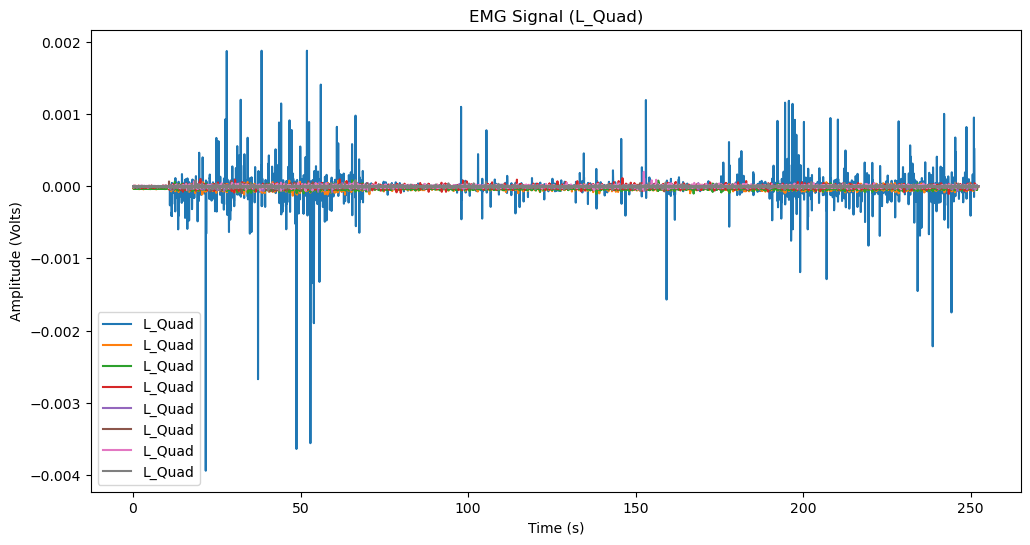

In [18]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

X = X.astype(np.float32)
y = y.astype(np.float32)

# Compute the time axis
t = np.arange(len(y)) / 30.0

# Plot the L_quad signal
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(t, X, label='L_Quad')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude (Volts)')
ax.set_title('EMG Signal (L_Quad)')
ax.legend()
plt.show()

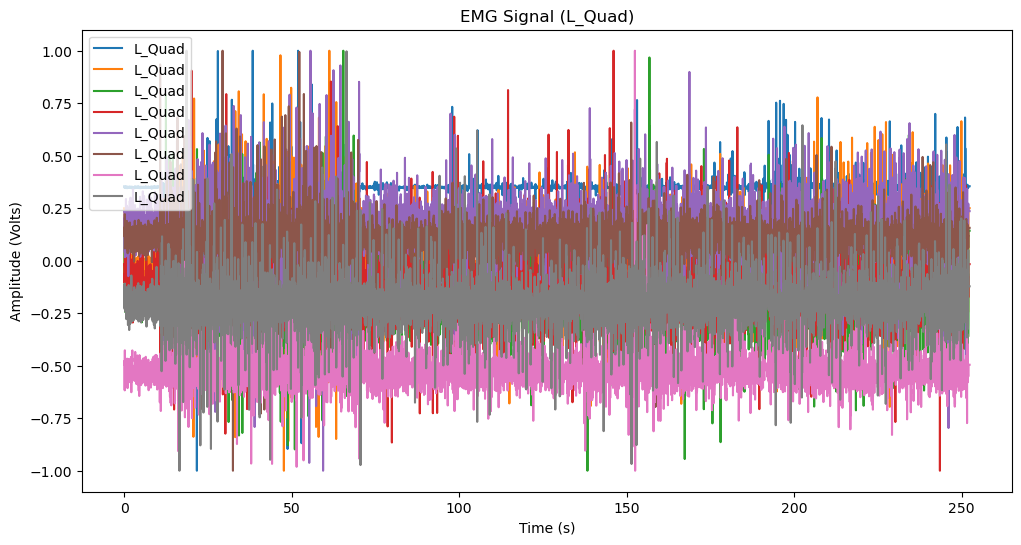

In [19]:
# normalize the data using the min-max scaler
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)

# Plot the L_quad signal
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(t, X, label='L_Quad')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude (Volts)')
ax.set_title('EMG Signal (L_Quad)')
ax.legend()
plt.show()


In [26]:
# define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X = X[:, 0].reshape(-1, 1)  # select only the L_quad signal
y = y.astype(np.float32)

# split data into train and test sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# reshape data
X_train = X_train.reshape(-1, 1, 1)
X_test = X_test.reshape(-1, 1, 1)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# instantiate model
input_size = 1
hidden_size = 32
num_layers = 2
output_size = 1

model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# train model
num_epochs = 100
for epoch in range(num_epochs):
    # set model to train mode
    model.train()

    # convert data to tensors and move to device
    inputs = torch.from_numpy(X_train).to(device)
    targets = torch.from_numpy(y_train).to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward pass
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # backward pass and optimize
    loss.backward()
    optimizer.step()

    # print loss
    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}')

# evaluate model
model.eval()
with torch.no_grad():
    inputs = torch.from_numpy(X_test).to(device)
    targets = torch.from_numpy(y_test).to(device)
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    print(f'Test Loss: {loss.item():.4f}')


Epoch [0/100], Loss: 1104.8278
Epoch [10/100], Loss: 1066.0951
Epoch [20/100], Loss: 934.1425
Epoch [30/100], Loss: 740.7124
Epoch [40/100], Loss: 593.2336
Epoch [50/100], Loss: 498.9123
Epoch [60/100], Loss: 435.7473
Epoch [70/100], Loss: 394.0595
Epoch [80/100], Loss: 367.6098
Epoch [90/100], Loss: 351.5451
Test Loss: 327.1560


transformer

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X = X.astype(np.float32)
y = y.astype(np.float32)

# standard normalization
X = (X - X.mean(axis=0)) / X.std(axis=0)

# split data into train and test sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# reshape data
X_train = X_train.reshape(-1, X.shape[1], 1)
X_test = X_test.reshape(-1, X.shape[1], 1)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

class Transformer(nn.Module):
    def __init__(self, input_size, output_size, num_layers, d_model, nhead, dim_feedforward):
        super(Transformer, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(input_size * d_model, output_size)

    def forward(self, x):
        # x.shape = (batch_size, seq_len, input_size)
        out = self.transformer_encoder(x.transpose(0, 1))
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)
        return out

# instantiate model
input_size = X.shape[1]
output_size = 1
num_layers = 2
d_model = 32
nhead = 4
dim_feedforward = 64

model = Transformer(input_size, output_size, num_layers, d_model, nhead, dim_feedforward).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# train model
num_epochs = 100
for epoch in range(num_epochs):
    # set model to train mode
    model.train()

    # convert data to tensors and move to device
    inputs = torch.from_numpy(X_train).to(device)
    targets = torch.from_numpy(y_train).to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward pass
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # backward pass and optimize
    loss.backward()
    optimizer.step()

    # print loss
    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}')

# evaluate model
model.eval()
with torch.no_grad():
    inputs = torch.from_numpy(X_test).to(device)
    targets = torch.from_numpy(y_test).to(device)
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    print(f'Test Loss: {loss.item():.4f}')


AssertionError: was expecting embedding dimension of 32, but got 1